## Rappel Google Colab

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. 
Installer ensuite deeplib avec la commande suivante:

In [1]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

  Cloning https://github.com/ulaval-damas/glo4030-labs.git to /tmp/pip-req-build-n7vhj_7a
  Running command git clone -q https://github.com/ulaval-damas/glo4030-labs.git /tmp/pip-req-build-n7vhj_7a
  Created wheel for deeplib: filename=deeplib-0.1-py3-none-any.whl size=7430 sha256=8c0c04df8da579768a3cb46c6dfb2d251545c2a8f210fc4f9edfb185f2a94000
  Stored in directory: /tmp/pip-ephem-wheel-cache-ssoxkli2/wheels/1b/15/04/08ace9de1b1bb3ab6b76e92ecb6123fa5756114c9c6051df36
Successfully built deeplib


# Laboratoire 4: Régularisation

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import poutyne as pt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from deeplib.datasets import load_cifar10, load_mnist, train_valid_loaders
from deeplib.net import CifarNet, CifarNetBatchNorm
from deeplib.training import train, test

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

cifar_train, cifar_test = load_cifar10()
mnist_train, mnist_test = load_mnist()

Files already downloaded and verified
Files already downloaded and verified


## 1. Régularisation L1 et L2

### Implémentation manuelle
La régularisation L2 est communément appelée **weight decay**. Dans PyTorch, les optimiseurs de `torch.optim` ont un paramètre `weight_decay` pour facilement utiliser cette régularisation. Par contre, on peut facilement implémenter manuellement la régularisation L2 comme une pénalité sur la norme des poids (voir le [chapitre 7.1](http://www.deeplearningbook.org/contents/regularization.html)).

#### Exercice
Complétez la fonction *loss_init* en ajoutant manuellement la pénalité sur les paramètres du réseau selon une régularisation L1 ou L2. Le paramètre *reg_alpha* correspond à l'hyperparamètre de régularisation $\alpha$ du livre ($\lambda$ dans les acétates du cours). Le paramètre *p* correspond à l'ordre de la norme: $p=1$ pour la norme L1 et $p=2$ pour la norme L2.

In [ ]:
def loss_init(parameters=[], reg_alpha=0, p=2):
    cross_entropy = nn.CrossEntropyLoss()
    
    def loss_function(output, targets):
        loss = cross_entropy(output,targets)
        
        for param in parameters:
            # TODO
            loss += reg_alpha/p * torch.norm(param, p=p) ** p
        
        return loss
    return loss_function

Testez votre implémentation de la régularisation par la norme L2 ($p=2$):

In [ ]:
torch.manual_seed(42)
net = CifarNet()
optimizer = optim.SGD(net.parameters(), lr=0.1)
loss = loss_init(net.parameters(), reg_alpha=1e-3, p=2)

train(net, optimizer, cifar_train, n_epoch=5, batch_size=64, use_gpu=True, criterion=loss)

Testez votre implémentation de la régularisation par la norme L1 ($p=1$):

In [ ]:
torch.manual_seed(42)
net = CifarNet()
optimizer = optim.SGD(net.parameters(), lr=0.1)
loss = loss_init(net.parameters(), reg_alpha=1e-3, p=1)

train(net, optimizer, cifar_train, n_epoch=5, batch_size=64, use_gpu=True, criterion=loss)

### Utilisation du *weight decay*

Explorons maintenant l'utilisation du paramètre `weight_decay` disponible dans les optimiseurs de `PyTorch` pour effectuer de la régularisation L2. Nous allons entrainez un réseau de neurones avec régularisation L2 et un autre sans pour pouvoir observer l'impact de la régularisation sur l'apprentissage et le réseau appris.

In [ ]:
# Paramètres
batch_size = 64
lr = 0.1
n_epoch = 15

Réseau sans régularisation L2:

In [ ]:
torch.manual_seed(42)
net_without_l2 = CifarNet()
optimizer_without_l2 = optim.SGD(net_without_l2.parameters(), lr=lr, weight_decay=0)

history_without_l2 = train(net_without_l2, optimizer_without_l2, cifar_train, n_epoch, batch_size, use_gpu=True)
history_without_l2.display()
print('Précision en test: {:.2f}'.format(test(net_without_l2, cifar_test, batch_size=64)))

Réseau avec régularisation L2 (*weight decay*):

In [ ]:
weight_decay = 1e-3

torch.manual_seed(42)
net_l2 = CifarNet()
optimizer_l2 = optim.SGD(net_l2.parameters(), lr=lr, weight_decay=weight_decay)

history_l2 = train(net_l2, optimizer_l2, cifar_train, n_epoch, batch_size, use_gpu=True)
history_l2.display()
print('Précision en test: {:.2f}'.format(test(net_l2, cifar_test, batch_size=64)))

#### Questions
- Quel est l'effet de la régularisation L2 sur l'entraînement du réseau? **Au niveau de l'accuracy, on remarque que les performances en validation et en test sont légèrement meilleures. Également, l'utilisation de la régularisation réduit le surapprentissage. En effet l'écart des valeurs d'accuracy et de loss entre l'entraînement et la validation est nettement moins important (voir graphiques)**
- Si vous utilisez un weight_decay trop grand (exemple 0.1) qu'arrive-t-il? Pourquoi? **Le réseau ne parvient tout simplement pas à apprendre car la pénalité sur les poids est trop importante.**

Dans la cellule suivante, analysez avec un histogramme la distribution des poids appris par les réseaux avec ou sans régularisation. 

- Que remarquez-vous? **Avec la régularisation L2, les poids appris sont plus concentrés près de 0.**

In [ ]:
def net_to_weight_array(net):
    weights = []
    for p in net.parameters():
        p_numpy = p.data.cpu().numpy()
        weights.append(p_numpy.reshape((-1))) # Reshape to 1D array
    return np.concatenate(weights)

weights_without_l2 = net_to_weight_array(net_without_l2)
weights_l2 = net_to_weight_array(net_l2)

# Visualisation
plt.hist(weights_without_l2, bins='auto', range=(-0.3, 0.3), alpha =0.5, label="Sans régularisation L2")
plt.hist(weights_l2, bins='auto', range=(-0.3, 0.3), alpha=0.5, label="Avec régularisation L2")
plt.legend()
plt.show()

## 2. Early stopping

Commencez par entraîner un réseau pour un grand nombre d'epoch. L'historique d'entraînement nous servira de base pour les questions qui suivent.

In [3]:
torch.manual_seed(42)
net = CifarNetBatchNorm()

optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-4, nesterov=True, momentum=0.9)
scheduler = pt.ReduceLROnPlateau(monitor='val_acc', mode='max', patience=5, factor=0.5, verbose=True)

history = train(net, optimizer, cifar_train, n_epoch=60, batch_size=64, callbacks=[scheduler], use_gpu=True)

Epoch: 1/60 Step: 625/625 100.00% |█████████████████████████|7.85s loss: 1.588104 acc: 45.500000 val_loss: 1.338226 val_acc: 52.140000
Epoch: 2/60 Step: 625/625 100.00% |█████████████████████████|8.41s loss: 1.185787 acc: 57.917500 val_loss: 1.202592 val_acc: 57.570000
Epoch: 3/60 Step: 625/625 100.00% |█████████████████████████|7.46s loss: 1.006857 acc: 64.520000 val_loss: 1.088743 val_acc: 62.420000
Epoch: 4/60 Step: 625/625 100.00% |█████████████████████████|7.90s loss: 0.877533 acc: 69.717500 val_loss: 1.002037 val_acc: 65.260000
Epoch: 5/60 Step: 625/625 100.00% |█████████████████████████|7.94s loss: 0.784581 acc: 72.877500 val_loss: 1.063464 val_acc: 63.290000
Epoch: 6/60 Step: 625/625 100.00% |█████████████████████████|8.34s loss: 0.702011 acc: 75.640000 val_loss: 0.932799 val_acc: 68.230000
Epoch: 7/60 Step: 625/625 100.00% |█████████████████████████|7.80s loss: 0.628415 acc: 78.340000 val_loss: 1.028405 val_acc: 65.470000
Epoch: 8/60 Step: 625/625 100.00% |████████████████████

Epoch: 37/60 Step: 625/625 100.00% |█████████████████████████|8.01s loss: 0.016937 acc: 99.992500 val_loss: 1.556689 val_acc: 68.010000
Epoch: 38/60 Step: 625/625 100.00% |█████████████████████████|7.84s loss: 0.016577 acc: 99.987500 val_loss: 1.572564 val_acc: 68.020000
Epoch: 39/60 Step: 625/625 100.00% |█████████████████████████|8.26s loss: 0.016302 acc: 99.995000 val_loss: 1.570813 val_acc: 68.060000
Epoch    39: reducing learning rate of group 0 to 3.1250e-04.
Epoch: 40/60 Step: 625/625 100.00% |█████████████████████████|8.21s loss: 0.016026 acc: 99.992500 val_loss: 1.568797 val_acc: 68.130000
Epoch: 41/60 Step: 625/625 100.00% |█████████████████████████|8.03s loss: 0.015946 acc: 99.997500 val_loss: 1.564991 val_acc: 68.160000
Epoch: 42/60 Step: 625/625 100.00% |█████████████████████████|7.84s loss: 0.015971 acc: 99.987500 val_loss: 1.569612 val_acc: 68.190000
Epoch: 43/60 Step: 625/625 100.00% |█████████████████████████|7.97s loss: 0.015812 acc: 99.987500 val_loss: 1.573316 val_a

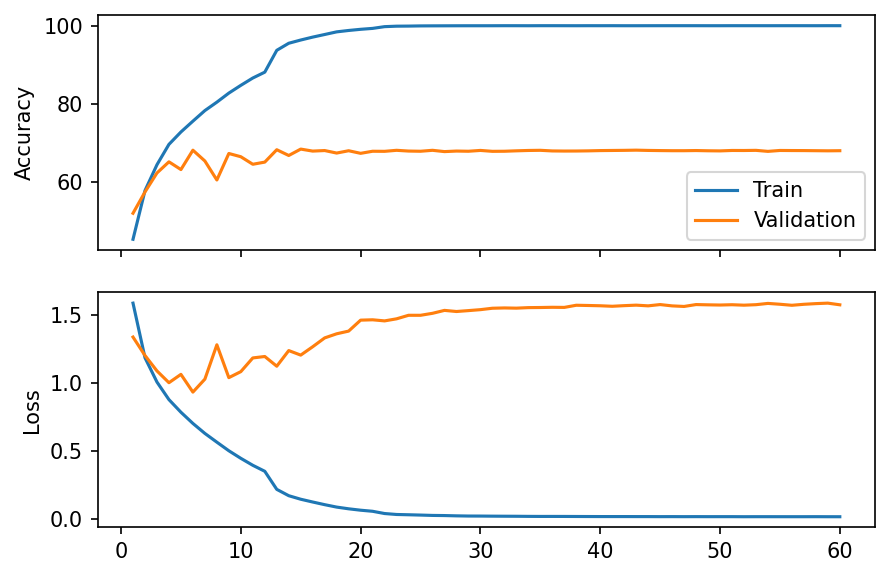

In [4]:
history.display()

#### Questions
- En regardant les graphiques ci-dessus, quel est le meilleur moment pour arrêter l'entraînement? Pourquoi?
- Identifiez des problèmes pratiques potentiels lors de l'utilisation de l'early stopping.

#### Exercice
L'algorithme 7.1 du livre (voir http://www.deeplearningbook.org/contents/regularization.html) décrit le paramètre de patience `p`. Analysez l'effet du choix de `p` sur les données de l'entraînement précédent. Regardez, pour `p = 1,5,10,15`, quel modèle avec quelle précision en validation est choisi. Utilisez les `val_accuracy` de l'entraînement que vous venez d'exécuter pour vos tests (à la place d'entraîner le réseau).

In [ ]:
p = 1
val_accuracy = history.history['val_acc']

print(val_accuracy[:4])
#TODO

## 3. Dropout
Cette section a pour but d'analyser l'effet du dropout dans un réseau fully connected. Nous ferons cette analyse en reprenant l'exercice du laboratoire 2.


In [ ]:
dataset, _ = load_mnist()

#### Exercice
Dans le réseau suivant, implémentez la fonction `forward()` en ajoutant du dropout si `self.use_dropout == True`. N'ajoutez **pas de softmax** car la fonction `deeplib.training.train()` utilise par défaut `CrossEntropyLoss`, ce qui le fait pour vous. Utilisez une probabilité de drop de `0.4`. Ne faites pas de dropout sur la couche de sortie.

> **ATTENTION!** Vous devez bien fixer l'argument `training` de dropout. Vous pouvez savoir si modèle est en entraînement ou en évaluation avec self.training.

### Question
- Quelle est l'importance de l'argument `training` de la fonction de dropout?

In [ ]:
class MnistModel(torch.nn.Module):
    
    def __init__(self, n_layers, hidden_size=100, use_dropout=True):
        super().__init__()
        torch.manual_seed(12345)
        self.use_dropout = use_dropout
        self.hidden_size = hidden_size
        
        layer_sizes = [28*28] + [self.hidden_size]*n_layers
        self.layers = nn.ModuleList()
        for input_size, output_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layer = nn.Linear(input_size, output_size)
            layer.weight.data.normal_(0.0, math.sqrt(2 / input_size))
            layer.bias.data.fill_(0.0001)
            self.layers.append(layer)
            
        self.output_layer = nn.Linear(hidden_size,10)
        self.output_layer.weight.data.normal_(0.0, math.sqrt(2 / hidden_size))
        self.output_layer.bias.data.fill_(0.0001)              

    def forward(self, x):
        out = x.view(-1, 28*28)
        pass
        #TODO

Entraînez un réseau avec dropout et un réseau sans dropout.

In [ ]:
net = MnistModel(2, use_dropout=False)
net_dropout = MnistModel(2, use_dropout=True)
net.cuda()
net_dropout.cuda()

optimizer = optim.SGD(net.parameters(), lr=0.005, nesterov=True, momentum=0.9)
optimizer_dropout = optim.SGD(net_dropout.parameters(), lr=0.005, nesterov=True, momentum=0.9)

history = train(net, optimizer, dataset, 20, batch_size=64)
history_dropout = train(net_dropout, optimizer_dropout, dataset, 20, batch_size=64)

In [ ]:
history.display()

In [ ]:
history_dropout.display()

#### Exercice
- Essayez plusieurs valeurs de dropout et observez les effets.
- Essayer d'avoir des valeurs différentes de probabilité de dropout pour chaque couche. Est-ce que cela améliore les résultats?